In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision import datasets, transforms
import numpy as np

Now define the model to be trained

In [2]:
class LeNet5(nn.Module):
	def __init__(self):
		super(LeNet5, self).__init__()
		self.conv1 = nn.Conv2d(1, 20, 5, 1)
		self.conv2 = nn.Conv2d(20, 50, 5, 1)
		self.fc1 = nn.Linear(4*4*50, 500)
		self.fc2 = nn.Linear(500, 10)

	def forward(self, x):
		x = F.relu(self.conv1(x))
		x = F.max_pool2d(x, 2, 2)
		x = F.relu(self.conv2(x))
		x = F.max_pool2d(x, 2, 2)
		x = x.view(-1, 4*4*50)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x


Various utility functions, like training and accuracy routines

In [3]:
def accuracy_MNIST(model, metrics, test_loader, device):
	model.eval()
	test_loss = 0
	correct = 0
	tot = 0
	CM=0
	with torch.no_grad():
		for xb, yb in test_loader:
			xb = xb.to(device)
			yb = yb.to(device)
			output = model(xb)
			test_loss += metrics(output, yb).item()
			pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
			correct += pred.eq(yb.view_as(pred)).sum().item()
			tot += len(pred)
	test_loss /= len(test_loader)
	return test_loss, (float(correct) /tot)*100


def train_MNIST(model, optimizer, metrics, train_loader, device):
	model.train()
	for xb, yb in train_loader:
		xb = xb.to(device)
		yb = yb.to(device)
		output = model(xb)
		loss = metrics(output, yb)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

Set a number of hyperparameters and eventually a training

In [4]:
batch_size =100
seed = 1
device = torch.device("cuda:0")
torch.cuda.set_device(device)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if False:
    dataset_path = "/home/tarta/data/MNIST"
    save_model_name = 'models/LeNet5.pt'
    epochs = 10
    lr = 0.1
    weight_decay = 0.0

    model = LeNet5().to(device)
    loss_func = nn.CrossEntropyLoss().to(device)

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]
    )

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=dataset_path, train=True, download=True, transform=transform),
        batch_size=batch_size
    )

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform),
        batch_size=100
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    results = accuracy_MNIST(model, loss_func, test_loader, device)
    print(0, results)
    for ep in range(epochs):
        train_MNIST(model, optimizer, loss_func, train_loader, device)
        results = accuracy_MNIST(model, loss_func, test_loader, device)
        print(ep+1, results)

    model = model.to("cpu")
    torch.save(model.state_dict(), save_model_name)

Compute the 1st order entropy contributions

In [5]:
from src.PSPentropy import compute_PSPentropy
dataset_path = "/home/tarta/data/MNIST"
load_model_name = 'models/LeNet5.pt'

model = LeNet5()
model.load_state_dict(torch.load(load_model_name))
model = model.to(device)

transform = transforms.Compose(
	[
		transforms.ToTensor(),
		transforms.Normalize((0.1307,), (0.3081,))
	]
)

test_loader = torch.utils.data.DataLoader(
	datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform),
	batch_size=100
)

H, H_classwise = compute_PSPentropy(model, test_loader, device, order = 1)

Plot the contributions layer by layer

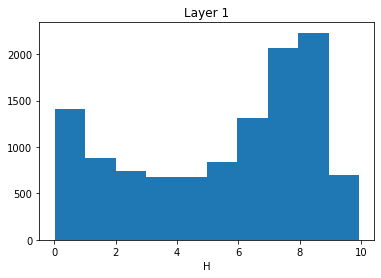

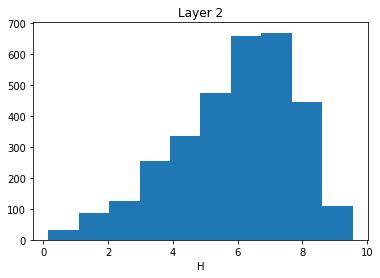

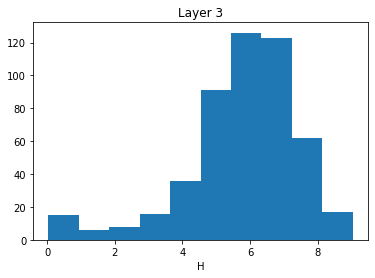

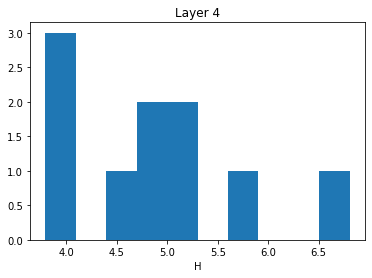

In [6]:
import matplotlib.pyplot as plt

for idx in range(len(H)):
    this_H = H[idx].cpu().reshape(-1).numpy()
    plt.hist(this_H)
    plt.title("Layer "+str(idx+1))
    plt.xlabel("H")
    plt.show()

Plot the detail in a single layer, class by class

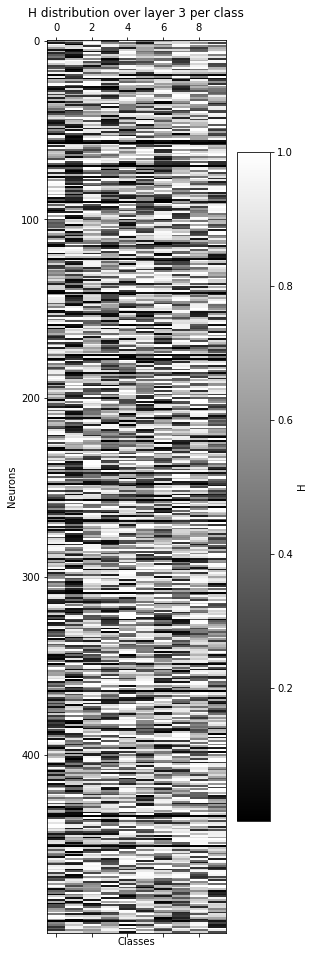

In [7]:
this_H = H_classwise[2].cpu().reshape(500,10).numpy()
plt.matshow(this_H, aspect='auto', cmap='gray')
plt.title("H distribution over layer 3 per class")
plt.xlabel("Classes")
plt.ylabel("Neurons")
plt.colorbar(label='H')
plt.show()